#### Update Previous Neighbor Data
Test utility to measure the performance of several implementations of  `test/individuals/update_previous_neighbor_data` in multiple languages.

In [45]:
import os


languages_to_test = []

for dir in os.listdir("."):
    if "." not in dir:
        languages_to_test.append(dir)

In [46]:
import subprocess

def build_test(build_command):
    subprocess.run(build_command, shell=True)


def get_test_data(test_command):
    bytes = subprocess.check_output(test_command)
    bytes_string = bytes.decode("utf-8") \
                         .replace("\r", "") \
                         .replace("\n", "") \
                         .replace(" ", "")

    memory, runtime = bytes_string.split(",")   
    memory = int(memory)
    runtime = float(runtime)     
                         
    return (memory, runtime)

In [47]:
import platform
import os
from pathlib import Path


language_commands = {
  "go": { 
    "test": "go run ./go/{version}/main.go"
  },
  "cpp": {
    "build": "g++ -std=c++11 ./cpp/{version}/main.cpp -o ./cpp/{version}/main",
    "test": "./cpp/{version}/main"
  },
  "python": {
    "test": "python3 ./python/{version}/main.py"
  },
  "java": {
    "build": "javac ./java/{version}/Main.java",
    "test": "java -cp " + str(Path(os.getcwd()).parent.parent.parent) + " test.individuals.update_previous_neighbor_data.java.{version}.Main"
  },
  "julia": {
    "test": "julia ./julia/{version}/main.jl"
  },
  "typescript": {
    "build": "npx --prefix ./typescript tsup ./typescript/{version}/main.ts -d ./typescript/{version}",
    "test": "node ./typescript/{version}/main.js"
  },
  "rust": {
    "build": "rustc ./rust/{version}/main.rs -o ./rust/{version}/main",
    "test": "./rust/{version}/main"
  },
  "scala": {},
  "fortran": {
    "build": "gfortran ./fortran/{version}/main.f90 -o ./fortran/{version}/main",
    "test": "./fortran/{version}/main"
  }
}

operating_system = platform.system().lower()

if operating_system == "windows":
    language_commands["scala"]["test"] = os.path.join(os.environ["USERPROFILE"], "AppData/Local/Coursier/data/bin/scala.bat ./scala/{version}/Main.scala")
  
    for language in ["cpp", "rust", "fortran"]:
      language_commands[language]["build"] = language_commands[language]["build"] + ".exe"
      language_commands[language]["test"] = language_commands[language]["test"] + ".exe"
      
elif operating_system == "darwin" or operating_system == "linux":
    language_commands["scala"]["test"] = "scala ./scala/{version}/Main.scala"

In [48]:
import datetime
import csv
import os


ITERATIONS = 75
tested_languages_data = []

for language_to_test in languages_to_test:
    versions_to_test = []
    for dir in os.listdir(language_to_test):
        if dir in ["optimized", "unoptimized"]:
            versions_to_test.append(dir)
 
    for version_to_test in versions_to_test:
        language_command = language_commands[language_to_test]
        
        if len(language_command) == 2:
            build_test(language_command["build"].format(version=version_to_test))

        memory_list = []
        runtime_list = []

        for _ in range(ITERATIONS):
            memory, runtime = get_test_data(language_command["test"].format(version=version_to_test))
            memory_list.append(memory)
            runtime_list.append(runtime)

        data_directory = os.path.join(language_to_test, version_to_test, "data")
        os.makedirs(data_directory, exist_ok=True)

        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        csv_file_path = os.path.join(data_directory, f"{timestamp}.csv")
        tested_languages_data.append({
          "language": language_to_test,
          "version": version_to_test,
          "csv_file_path": csv_file_path,
        })

        with open(csv_file_path, mode="w", newline="") as file:
            writer = csv.writer(file)
            writer.writerow(["Iteration", "Memory", "Runtime"])

            for i in range(len(memory_list)):
                writer.writerow([i, memory_list[i], runtime_list[i]])

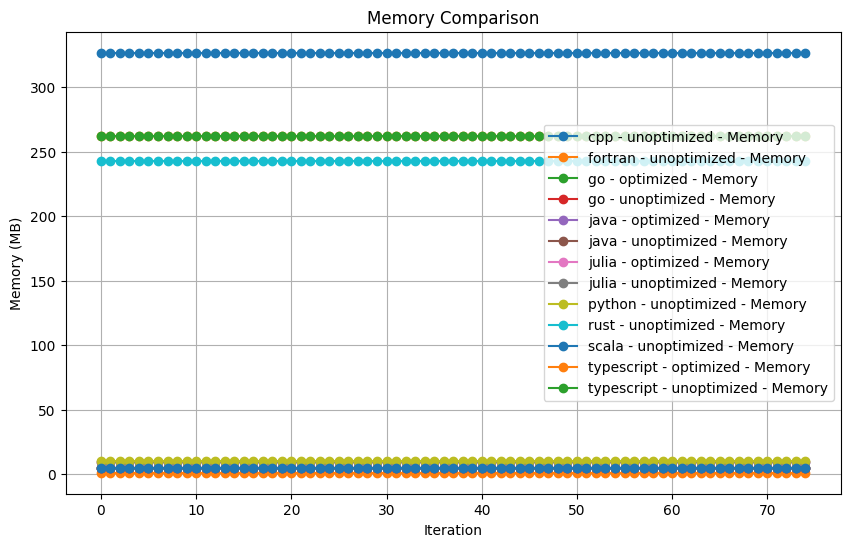

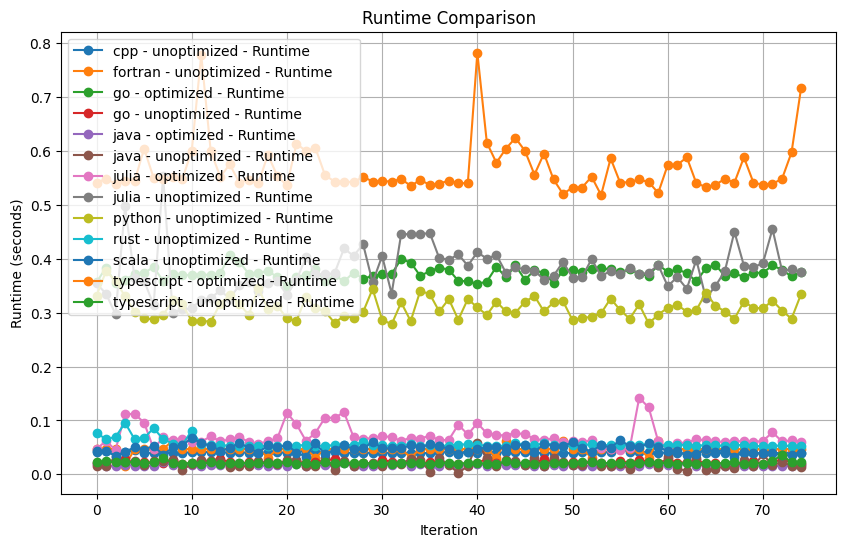

In [49]:
import csv
import matplotlib.pyplot as plt


memory_data = []
runtime_data = []

for tested_language_data in tested_languages_data:
    csv_file_path = tested_language_data["csv_file_path"]
    test_name = f"{tested_language_data['language']} - {tested_language_data['version']}"

    test_data = []
    with open(csv_file_path, mode="r") as file:
        reader = csv.DictReader(file)
        for row in reader:
            test_data.append(row)

    iterations = [int(data["Iteration"]) for data in test_data]
    memory_values = [float(data["Memory"]) / 1024 / 1024 for data in test_data]
    runtime_values = [float(data["Runtime"]) for data in test_data]

    memory_data.append((test_name, iterations, memory_values))
    runtime_data.append((test_name, iterations, runtime_values))

plt.figure(figsize=(10, 6))
for test_name, iterations, memory_values in memory_data:
    plt.plot(iterations, memory_values, marker="o", label=f"{test_name} - Memory")
plt.xlabel("Iteration")
plt.ylabel("Memory (MB)")
plt.title("Memory Comparison")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
for test_name, iterations, runtime_values in runtime_data:
    plt.plot(iterations, runtime_values, marker="o", label=f"{test_name} - Runtime")
plt.xlabel("Iteration")
plt.ylabel("Runtime (seconds)")
plt.title("Runtime Comparison")
plt.legend()
plt.grid(True)
plt.show()
